# **1. Installing Library**


In [2]:
# pip install scikit-optimize

# **2. Import Library**


In [3]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from datetime import datetime,timedelta
from skopt import BayesSearchCV
from skopt.space import Integer
from sklearn.ensemble import RandomForestClassifier


# **3. Load Dataset**


In [4]:
df = pd.read_csv('dataset\irradiance_dataset')
df.head()

<>:1: SyntaxWarning: invalid escape sequence '\i'
<>:1: SyntaxWarning: invalid escape sequence '\i'
C:\Users\Acer\AppData\Local\Temp\ipykernel_12988\1717908015.py:1: SyntaxWarning: invalid escape sequence '\i'
  df = pd.read_csv('dataset\irradiance_dataset')


,ALLSKY_SFC_SW_DWN,PS,QV2M,T2M,time,hour,dayofweek,quarter,month,year,dayofyear
0,0.0,91.02,16.27,20.66,2021053000,0,6,2,5,2021,150
1,0.0,90.95,16.11,20.50,2021053001,1,6,2,5,2021,150
2,0.0,90.90,15.94,20.29,2021053002,2,6,2,5,2021,150
3,0.0,90.89,15.71,20.01,2021053003,3,6,2,5,2021,150
4,0.0,90.92,15.48,19.77,2021053004,4,6,2,5,2021,150


# **4. Exploratory Data Analysis (EDA)**

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26304 entries, 0 to 26303
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   ALLSKY_SFC_SW_DWN  26304 non-null  float64
 1   PS                 26304 non-null  float64
 2   QV2M               26304 non-null  float64
 3   T2M                26304 non-null  float64
 4   time               26304 non-null  int64  
 5   hour               26304 non-null  int64  
 6   dayofweek          26304 non-null  int64  
 7   quarter            26304 non-null  int64  
 8   month              26304 non-null  int64  
 9   year               26304 non-null  int64  
 10  dayofyear          26304 non-null  int64  
dtypes: float64(4), int64(7)
memory usage: 2.2 MB


In [6]:
df['datetime'] = pd.to_datetime(df['time'], format='%Y%m%d%H')
df.head()

,ALLSKY_SFC_SW_DWN,PS,QV2M,T2M,time,hour,dayofweek,quarter,month,year,dayofyear,datetime
0,0.0,91.02,16.27,20.66,2021053000,0,6,2,5,2021,150,2021-05-30 00:00:00
1,0.0,90.95,16.11,20.50,2021053001,1,6,2,5,2021,150,2021-05-30 01:00:00
2,0.0,90.90,15.94,20.29,2021053002,2,6,2,5,2021,150,2021-05-30 02:00:00
3,0.0,90.89,15.71,20.01,2021053003,3,6,2,5,2021,150,2021-05-30 03:00:00
4,0.0,90.92,15.48,19.77,2021053004,4,6,2,5,2021,150,2021-05-30 04:00:00


In [7]:
new_df = df[['datetime','ALLSKY_SFC_SW_DWN','hour','dayofweek','month','year','dayofyear','quarter']]
new_df = new_df.set_index('datetime')
new_df.head()

,ALLSKY_SFC_SW_DWN,hour,dayofweek,month,year,dayofyear,quarter
datetime,,,,,,,
2021-05-30 00:00:00,0.0,0,6,5,2021,150,2
2021-05-30 01:00:00,0.0,1,6,5,2021,150,2
2021-05-30 02:00:00,0.0,2,6,5,2021,150,2
2021-05-30 03:00:00,0.0,3,6,5,2021,150,2
2021-05-30 04:00:00,0.0,4,6,5,2021,150,2


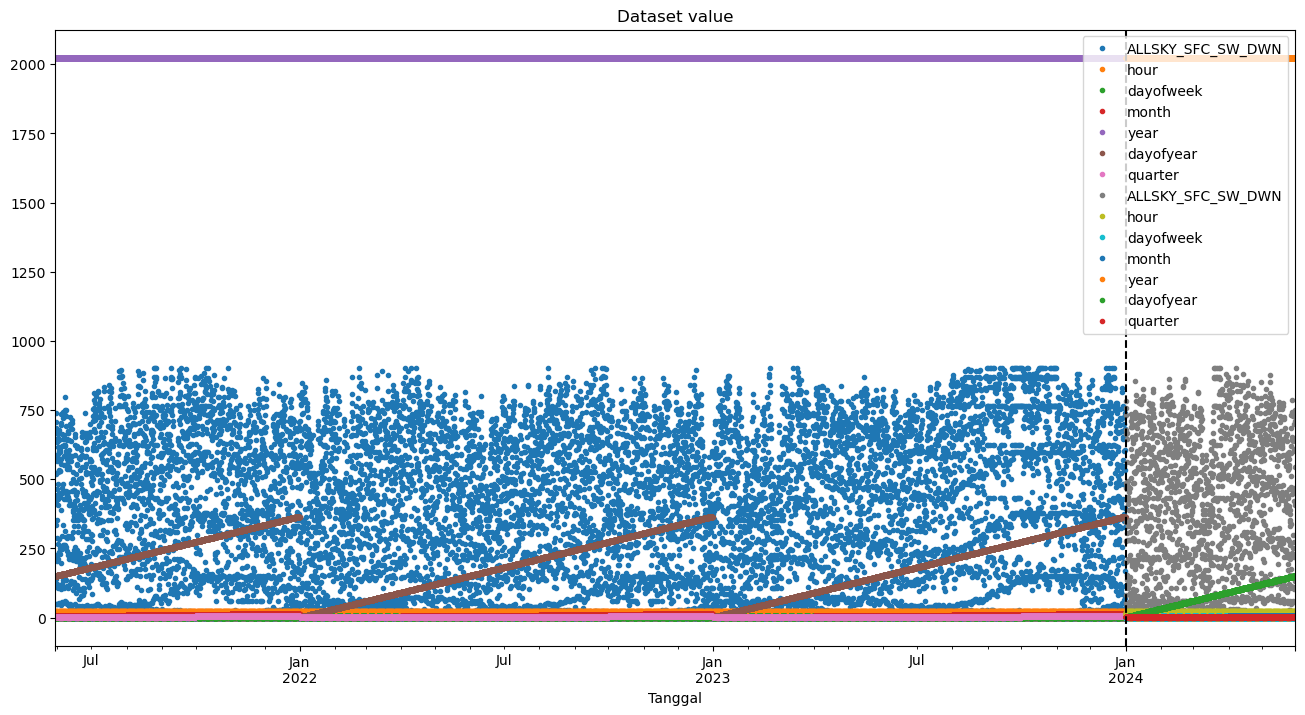

In [8]:
train = new_df.loc[new_df.index < '01-01-2024 00:00:00']
test = new_df.loc[new_df.index >= '01-01-2024 00:00:00']

fig, ax = plt.subplots(figsize=(16,8))
train.plot(ax=ax , label='train',style='.')
test.plot(ax=ax, label='test',style='.')
ax.axvline('01-01-2024',color='black',ls='--')
ax.legend(loc='upper right')
ax.set_xlabel('Tanggal')
ax.set_title("Dataset value")
plt.show()

# **5. Building Regresion Model**

In [9]:
FEATURES = ['hour', 'dayofweek', 'quarter', 'month', 'year','dayofyear']
TARGET = 'ALLSKY_SFC_SW_DWN'

x_train = train[FEATURES]
y_train = train[TARGET]

x_test = test[FEATURES]
y_test = test[TARGET]

In [10]:

rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)
rf_regressor.fit(x_train, y_train)

RandomForestRegressor(random_state=42)

In [11]:
y_pred = rf_regressor.predict(x_test)
y_pred

array([0., 0., 0., ..., 0., 0., 0.])

In [12]:
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print('Mean Squared Error:', mse)
print('R-squared:', r2)

Mean Squared Error: 6385.013623896052
R-squared: 0.9110087936123681


# **6. Hyperparameter Using BayesSearch**

In [13]:
param_grid = {
    'n_estimators': Integer(50, 500),
    'max_depth': Integer(3, 30),
    'min_samples_split': Integer(2, 20),
    'min_samples_leaf': Integer(1, 20)
}
opt = BayesSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    search_spaces=param_grid,
    n_iter=50,
    cv=3,
    scoring='neg_mean_squared_error',
    random_state=42,
    n_jobs=-1
)

In [14]:
opt.fit(x_train, y_train)
print(opt.best_estimator_)


e:\Anaconda\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [16, 20, 20, 50] before, using random point [26, 4, 12, 158]
  warnings.warn(
e:\Anaconda\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [16, 20, 20, 50] before, using random point [24, 14, 9, 62]
  warnings.warn(
e:\Anaconda\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [16, 20, 20, 50] before, using random point [19, 5, 7, 398]
  warnings.warn(


RandomForestRegressor(max_depth=9, min_samples_leaf=20, n_estimators=500,
                      random_state=42)


In [15]:
y_pred_bayes = opt.predict(x_test)
y_pred_bayes

array([0., 0., 0., ..., 0., 0., 0.])

In [16]:
bayes_mse = mean_squared_error(y_test, y_pred_bayes)
bayes_r2 = r2_score(y_test, y_pred_bayes)

print('Mean Squared Error:', bayes_mse)
print('R-squared:', bayes_r2)

Mean Squared Error: 4546.791913043174
R-squared: 0.9366290314525055


In [17]:
test['prediction1'] = y_pred
test['prediction_beyes'] = y_pred_bayes
last_df = new_df.merge(test['prediction1'], how='left', left_index=True, right_index=True)
last_df = last_df.merge(test['prediction_beyes'], how='left', left_index=True, right_index=True)
last_df.head()

C:\Users\Acer\AppData\Local\Temp\ipykernel_12988\3310411478.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['prediction1'] = y_pred
C:\Users\Acer\AppData\Local\Temp\ipykernel_12988\3310411478.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['prediction_beyes'] = y_pred_bayes


,ALLSKY_SFC_SW_DWN,hour,dayofweek,month,year,dayofyear,quarter,prediction1,prediction_beyes
datetime,,,,,,,,,
2021-05-30 00:00:00,0.0,0,6,5,2021,150,2,NaN,NaN
2021-05-30 01:00:00,0.0,1,6,5,2021,150,2,NaN,NaN
2021-05-30 02:00:00,0.0,2,6,5,2021,150,2,NaN,NaN
2021-05-30 03:00:00,0.0,3,6,5,2021,150,2,NaN,NaN
2021-05-30 04:00:00,0.0,4,6,5,2021,150,2,NaN,NaN


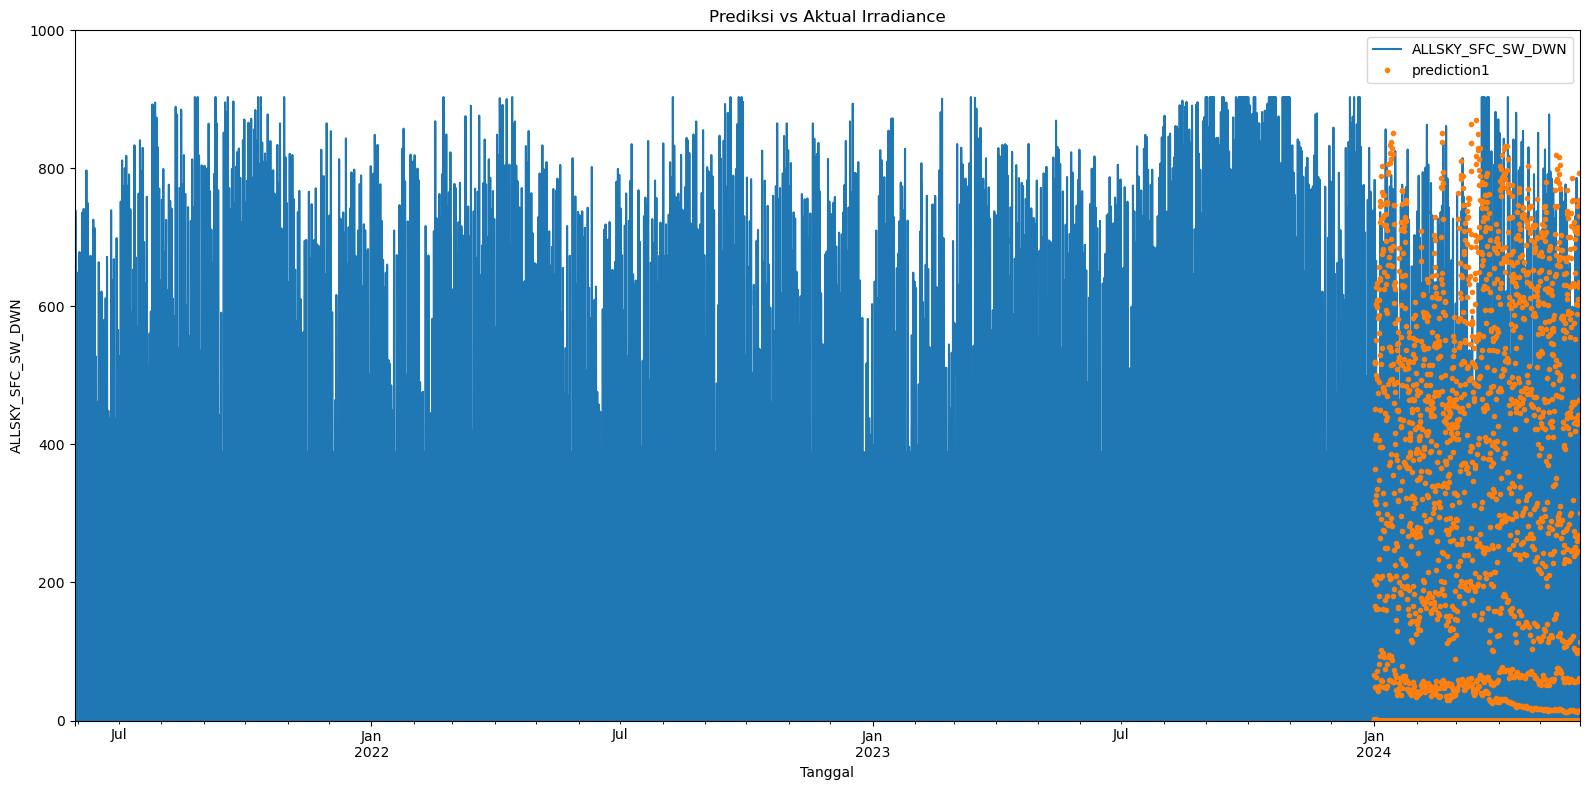

In [26]:
fig, ax = plt.subplots(figsize=(16, 5))
actual_value = last_df['ALLSKY_SFC_SW_DWN'].plot(figsize=(16,8))
prediction_value = last_df['prediction1'].plot(ax=ax, style='.')

actual_value.plot(ax=ax, label='Actual', color='blue')
prediction_value.plot(ax=ax, style='.', label='Prediction bayes', color='orange')

ax.set_ylabel('ALLSKY_SFC_SW_DWN')
ax.set_xlabel('Tanggal')
ax.set_title("Prediksi vs Aktual Irradiance")

ax.legend(loc='upper right')
plt.ylim((0,1000))
plt.tight_layout()
plt.show()

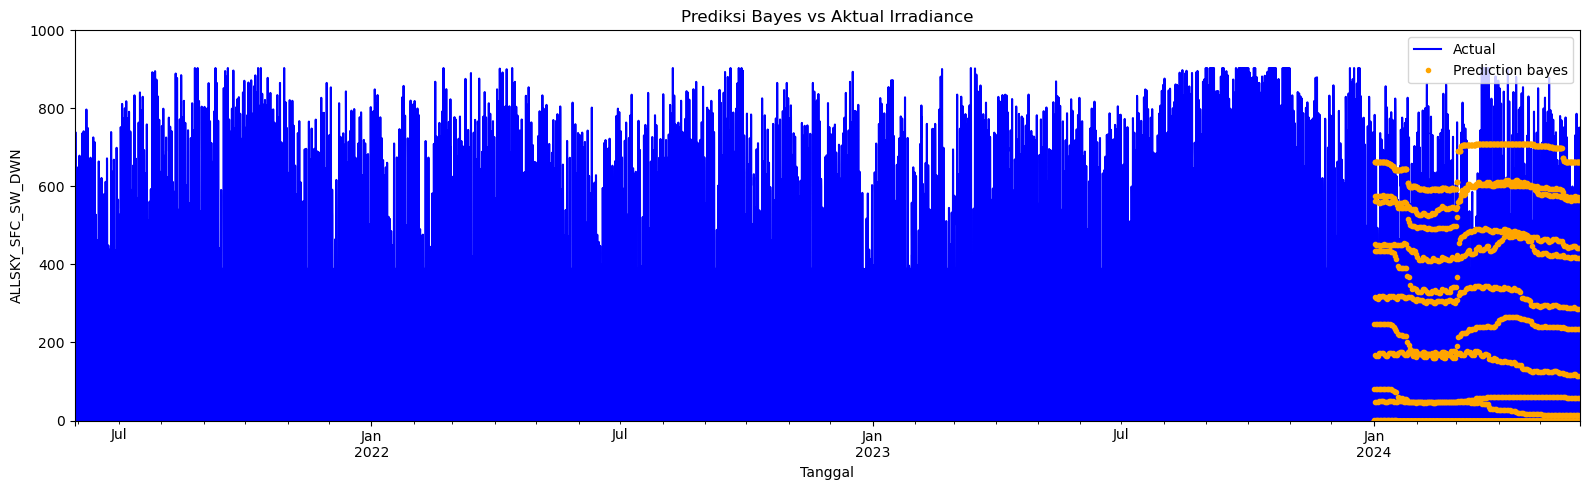

In [27]:
fig, ax = plt.subplots(figsize=(16, 5))
actual_value = last_df['ALLSKY_SFC_SW_DWN']
bayes_value = last_df['prediction_beyes']

actual_value.plot(ax=ax, label='Actual', color='blue')
bayes_value.plot(ax=ax, style='.', label='Prediction bayes', color='orange')

ax.set_ylabel('ALLSKY_SFC_SW_DWN')
ax.set_xlabel('Tanggal')
ax.set_title("Prediksi Bayes vs Aktual Irradiance")

ax.legend(loc='upper right')
plt.ylim((0,1000))
plt.tight_layout()
plt.show()

# **7. Compare models before and after hyperparameters**

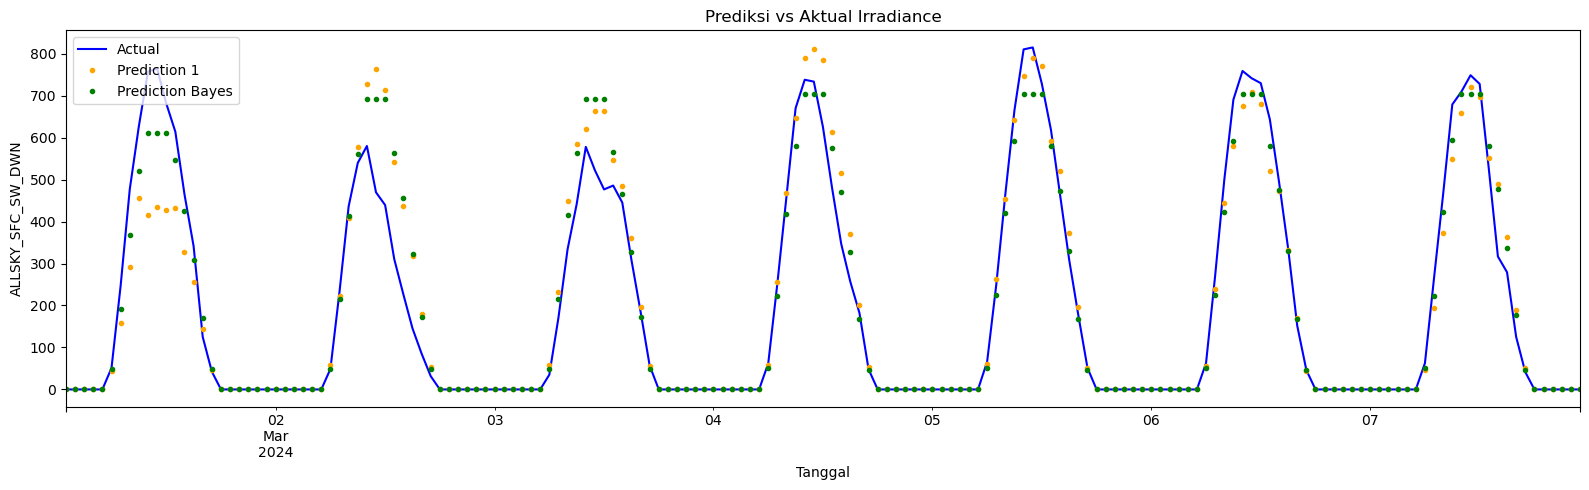

In [ ]:

fig, ax = plt.subplots(figsize=(16, 5))
true_vals = last_df.loc[(last_df.index > '03-01-2024') & (last_df.index < '03-08-2024')]['ALLSKY_SFC_SW_DWN']
pred1_vals = last_df.loc[(last_df.index > '03-01-2024') & (last_df.index < '03-08-2024')]['prediction1']
pred_bayes_vals = last_df.loc[(last_df.index > '03-01-2024') & (last_df.index < '03-08-2024')]['prediction_beyes']


true_vals.plot(ax=ax, label='Actual', color='blue')
pred1_vals.plot(ax=ax, style='.', label='Prediction 1', color='orange')
pred_bayes_vals.plot(ax=ax, style='.', label='Prediction Bayes', color='green')
ax.set_ylabel('ALLSKY_SFC_SW_DWN')
ax.set_xlabel('Tanggal')
ax.set_title("Prediksi vs Aktual Irradiance")

ax.legend()
plt.tight_layout()
plt.show()


# **8. Saving Model Evaluation**

In [29]:
evaluation = pd.DataFrame ({    
    'model' : ['Randomforest', 'Randomforest BayesSearchCV'],
    'r2_score' : [r2, bayes_r2],
    'Mean Squared Error' : [mse, bayes_mse],
    })
evaluation

,model,r2_score,Mean Squared Error
0,Randomforest,0.911009,6385.013624
1,Randomforest BayesSearchCV,0.936629,4546.791913


In [30]:
evaluation.to_csv('Evaluation_Model_Score', encoding='utf-8', index=False)